In [9]:
import pandas as pd

In [10]:
import os
os.getcwd()

'/content'

목표 설정
- 네이버 영화 리뷰 데이터셋을 이용해서 긍정/부정을 판별하는 분류기를 만들어보자.
- TF-IDF 방법을 이용해서 토큰화를 진행해보자.
- Konlpy 한국어 형태소 분석기 이용해보자.
- 단어별 긍정/부정 정보를 시각화해서 알아보자

In [11]:
#나눔고딕 설치
!sudo apt-get install fonts-nanum* #폰트 설치
!sudo fc-cache -fv #폰트 캐시 갱신
!rm -/.cache/matplotlib -rf #폰트 캐시 삭제

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 41 not upgraded.
Need to get 46.0 MB of archives.
After this operation, 177 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-eco all 1.000-7 [14.7 MB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0

In [106]:
import matplotlib.pyplot as plt
plt.rc('font', family='Apple Gothic') #한글이 지원되는 폰트 설정
plt.rcParams['axes.unicode_minus'] = False #마이너스 기호 지원

In [13]:
# 내 컴퓨터가 구글의 어느곳에 연결돼서 위치하는지 확인
# 내 현재 작업의 위치 확인
!pwd

/content


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!pwd

/content


In [16]:
#소스코드가 있는 경로로 위치를 변경
%cd /content/drive/MyDrive/Colab Notebooks/east

/content/drive/MyDrive/Colab Notebooks/east


In [17]:
!pwd

/content/drive/MyDrive/Colab Notebooks/east


In [18]:
import pandas as pd

In [19]:
train = pd.read_csv("data/ratings_train.csv", encoding='utf-8')
test = pd.read_csv("data/ratings_test.csv", encoding='utf-8')

In [20]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [21]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [24]:
# 결측치가 존재
# 확인
train[train['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [25]:
test[test['document'].isnull()]

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


In [26]:
# .dropna() : 결측ㅊ가 있는 행 삭제
train.dropna(inplace=True)
test.dropna(inplace=True)

In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49997 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49997 non-null  int64 
 1   document  49997 non-null  object
 2   label     49997 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [28]:
# train test 문제 정답 분리
# 어떤 컬럼이 문제데이터가 되고, 어떤 컬럼이 정답데이터가 되어야 할까?

In [29]:
train.head()
#0 부정
#1 긍정
#평점 8점 이상 => 1(긍정)
#평점 4점 이하 => 0(부정)
#5~7점 => 제외함

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [30]:
train['label'].value_counts()

,count
label,
0,75170
1,74825


In [31]:
#학습데이터의 정답 데이터
train['label']
test['label']

,label
0,1
1,0
2,0
3,0
4,0
...,...
49995,1
49996,0
49997,0
49998,0


In [32]:
#train/test 셋에서 X_train, y_train, X_test, y_test로 분류하기
X_train = train['document']
y_train = train['label']
X_test = test['document']
y_test = test['label']

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((149995,), (149995,), (49997,), (49997,))

In [34]:
###토큰화
#vectorizer는 말 그대로 벡터화 시켜주는 도구
#벡터화 : 텍스트나 이미지처럼 '비수치적'인 데이터를 '숫자 배열(벡터)'로 바꾸는 과정
#기계 학습 분야에서 주로 텍스트 데이터를 쉽게 분석하기 위해서 벡터화
#숫자 / 벡터로 입력받기를 기대하는 머신러닝/딥러닝 모델을 실행하기 위해서는 텍스트나 또다른 형태의 데이터를 벡터화/수치화 할 필요가 있다.
#이때 사용하는 도구가 vectorizer이다

In [35]:
###BOW(Bag of Word) 단어가방
#문서를 벡터로 변환하는 가장 기본적인 방법
#문서내에 모든 단어를 모아서 가방을 만들고 특정 문서에 어떤 단어가 들어있는지 리스트/딕셔너리 형태로 순서-숫자로 나타내는 방법

In [36]:
#TF-IDF 기법 사용
from sklearn.feature_extraction.text import TfidfVectorizer

In [37]:
X_train[0:3]

,document
0,아 더빙.. 진짜 짜증나네요 목소리
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2,너무재밓었다그래서보는것을추천한다


In [38]:
#TF-IDF 벡터라이저 사용

#객체 생성
tfidf = TfidfVectorizer()

#단어사전 구축
tfidf.fit(X_train[0:3])

TfidfVectorizer()

In [39]:
#분리된 단어로 만든 단어사전 출력
tfidf.vocabulary_
#결과를 보니 띄어쓰기를 기준으로 분류한 것 같음.

{'더빙': 2,
 '진짜': 6,
 '짜증나네요': 7,
 '목소리': 3,
 '포스터보고': 9,
 '초딩영화줄': 8,
 '오버연기조차': 5,
 '가볍지': 0,
 '않구나': 4,
 '너무재밓었다그래서보는것을추천한다': 1}

In [40]:
temp = TfidfVectorizer()
sugar = '설탕국수를냠냠쩝쩝맛있게 먹었다.'

#단어사전 구축
temp.fit([sugar])

temp.vocabulary_

{'설탕국수를냠냠쩝쩝맛있게': 1, '먹었다': 0}

-TF-IDF 벡터라이저는 기본적으로 어절 단위(문장을 이루는 토막)으로 끊어주기 때문에 한국어 특성상 파악이 어렵다.
- 더 작은 단위인 형태소 별로 나눠서 파악해야 한다.

In [41]:
### 한국어 형태소 분석기 사용해보기
# 한국어 특성에 맞춰 개발된 분석기를 사용해보자
#라이브러리 설치
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 49.4 MB/s eta 0:00:00


In [42]:
# 형태소 분석기 불러오기
from konlpy.tag import Kkma

Kkma(꼬꼬마)
- 서울대학교 IDS 연구실에서 개발

In [43]:
#꼬꼬마 객체 생성
kkma = Kkma()

꼬꼬마에서 사용되는 대표적인 함수
- nouns() : 명사 추출 함수
- morphs() : 형태소를 추출
- pos() : 형태소 추출 + 품사 태그

In [44]:
sugar

'설탕국수를냠냠쩝쩝맛있게 먹었다.'

In [45]:
kkma.nouns(sugar)

['설탕', '국수']

In [46]:
# tfidf + kkma 명사 추출기 연결해서 사용해보기
# TF-IDF vectorizer에 연결하기 위해서 명사 추출기 함수로 만들어보자
def myTokenizer(text):
  return kkma.nouns(text)

In [47]:
tfidf_nouns = TfidfVectorizer(tokenizer=myTokenizer)

#적용
tfidf_nouns.fit(X_train[0:3])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(tokenizer=<function myTokenizer at 0x785ff07db7e0>)

In [48]:
#단어사전 확인
tfidf_nouns.vocabulary_

{'더빙': 0,
 '목소리': 2,
 '흠': 17,
 '포스터': 15,
 '포스터보고': 16,
 '보고': 4,
 '초': 12,
 '초딩영화줄': 13,
 '딩': 1,
 '영화': 6,
 '줄': 11,
 '오버': 7,
 '오버연기': 8,
 '연기': 5,
 '재': 9,
 '재밓': 10,
 '밓': 3,
 '추천': 14}

In [49]:
#형태소 추출 함수
X_train[0]

'아 더빙.. 진짜 짜증나네요 목소리'

In [50]:
#형태소 추출 함수 morphs()
kkma.morphs(X_train[0])

['아', '아', '더빙', '..', '진짜', '짜증나', '네요', '목소리']

In [51]:
#품사태그 종류 출력해보기
kkma.tagset

{'EC': '연결 어미',
 'ECD': '의존적 연결 어미',
 'ECE': '대등 연결 어미',
 'ECS': '보조적 연결 어미',
 'EF': '종결 어미',
 'EFA': '청유형 종결 어미',
 'EFI': '감탄형 종결 어미',
 'EFN': '평서형 종결 어미',
 'EFO': '명령형 종결 어미',
 'EFQ': '의문형 종결 어미',
 'EFR': '존칭형 종결 어미',
 'EP': '선어말 어미',
 'EPH': '존칭 선어말 어미',
 'EPP': '공손 선어말 어미',
 'EPT': '시제 선어말 어미',
 'ET': '전성 어미',
 'ETD': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JK': '조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKI': '호격 조사',
 'JKM': '부사격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JX': '보조사',
 'MA': '부사',
 'MAC': '접속 부사',
 'MAG': '일반 부사',
 'MD': '관형사',
 'MDN': '수 관형사',
 'MDT': '일반 관형사',
 'NN': '명사',
 'NNB': '일반 의존 명사',
 'NNG': '보통명사',
 'NNM': '단위 의존 명사',
 'NNP': '고유명사',
 'NP': '대명사',
 'NR': '수사',
 'OH': '한자',
 'OL': '외국어',
 'ON': '숫자',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'UN': '명사추정범주',
 'VA': '형용사',
 'VC': '지정사',
 'VCN': "부정 지정사, 형용사 '아니다'",
 'VC

In [52]:
#우리가 지금 진행하고 있는 분석은 감성분류분석(긍정/부정)
#감성분석에서는 동사/형용사/보통명사를 많이 사용한다.
#동사/형용사/보통명사만 따로 가져오자

In [53]:
###pos 태깅 활용방법 알아보기
# 형태소의 품사를 자동으로 식별
# 더미데이터
data = '프랑스월드컵 콩국수 먹는다 먹다 먹었다 맛없다 이상하다 안에 설탕'

In [54]:
kkma.pos(data)

[('프랑스', 'NNG'),
 ('월드컵', 'NNG'),
 ('콩국수', 'NNG'),
 ('먹', 'VV'),
 ('는', 'EPT'),
 ('다', 'ECS'),
 ('먹', 'VV'),
 ('다', 'ECS'),
 ('먹', 'VV'),
 ('었', 'EPT'),
 ('다', 'ECS'),
 ('맛없', 'VA'),
 ('다', 'ECS'),
 ('이상', 'NNG'),
 ('하다', 'NNP'),
 ('안', 'NNG'),
 ('에', 'JKM'),
 ('설탕', 'NNG')]

In [55]:
#데이터프레임으로 만들어보자
df = pd.DataFrame(kkma.pos(data), columns=['morph','tag'])
df

,morph,tag
0,프랑스,NNG
1,월드컵,NNG
2,콩국수,NNG
3,먹,VV
4,는,EPT
5,다,ECS
6,먹,VV
7,다,ECS
8,먹,VV
9,었,EPT


In [56]:
#인덱스를 tag로 지정해보자
df.set_index('tag', inplace=True)

In [57]:
df

,morph
tag,
NNG,프랑스
NNG,월드컵
NNG,콩국수
VV,먹
EPT,는
ECS,다
VV,먹
ECS,다
VV,먹


In [58]:
# 문장데이터에 우리가 만들어준 토크나이저 적용해보자
# 적용 준비 단계 - 함수화

def myTokenizer2(text):

  #우리ㅏㄱ 사용할 품사만 뽑아보자
  d = pd.DataFrame(kkma.pos(text), columns=['morph', 'tag'])

  #인덱스를 태그로 지정해보자
  d.set_index('tag', inplace=True)

  #동사, 형용사, 보통명사만 뽑아서 데이터 프레임을 만들어보자
  #if ('VV' in d.index) | ('VA' in d.index) | ('NNG' in d.index):
  if d.index.isin(['VV','VA','NNG']).any(): #인덱스에 셋 중 하나라도 있으면,
    return d.loc[d.index.isin(['VV','VA','NNG']), 'morph'].values
    #return (d['morph'][d.index.isin(['VV','VA','NNG'])]).values
  else:
    return []

In [59]:
#TF-IDF Vectorizer에 연결
tfidf_pos = TfidfVectorizer(tokenizer=myTokenizer2)

#적용
tfidf_pos.fit(X_train[0:3])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TfidfVectorizer(tokenizer=<function myTokenizer2 at 0x785ff072d120>)

In [60]:
tfidf_pos.vocabulary_

{'아': 5,
 '더빙': 1,
 '짜증나': 12,
 '목소리': 2,
 '흠': 15,
 '포스터': 14,
 '보고': 4,
 '영화': 8,
 '줄': 11,
 '오버': 9,
 '연기': 7,
 '가볍': 0,
 '재': 10,
 '어': 6,
 '보': 3,
 '추천': 13}

In [61]:
#실제 데이터를 이용해서 단어사전 구축해보자
tfidf_final = TfidfVectorizer(tokenizer=myTokenizer2)
#10000개의 데이터를 이용해서 단어사전 구축
tfidf_final.fit(X_train[0:10000])

TfidfVectorizer(tokenizer=<function myTokenizer2 at 0x785ff072d120>)

In [62]:
tfidf_final.vocabulary_

{'아': 4671,
 '더빙': 1742,
 '짜증나': 7146,
 '목소리': 2611,
 '흠': 8699,
 '포스터': 8014,
 '보고': 3208,
 '영화': 5271,
 '줄': 6884,
 '오버': 5359,
 '연기': 5172,
 '가볍': 55,
 '재': 6338,
 '어': 4938,
 '보': 3205,
 '추천': 7428,
 '교도소': 693,
 '이야기': 5907,
 '멀': 2477,
 '재미': 6353,
 '없': 5041,
 '점': 6532,
 '조정': 6728,
 '익살': 5974,
 '돋보이': 1829,
 '스파이': 4371,
 '더': 1730,
 '맨': 2450,
 '늙': 1489,
 '보이': 3238,
 '하': 8148,
 '커스틴': 7565,
 '이쁘': 5879,
 '걸음마': 353,
 '떼': 2070,
 '초등학교': 7354,
 '학년': 8209,
 '생인': 3875,
 '용': 5522,
 '별': 3186,
 '반개': 2939,
 '아깝': 4677,
 '원작': 5630,
 '긴장감': 1044,
 '살리': 3740,
 '욕': 5513,
 '나오': 1205,
 '이응': 5925,
 '경': 417,
 '길': 1047,
 '우': 5538,
 '생활': 3882,
 '발': 2969,
 '낫': 1284,
 '납': 1281,
 '감금': 145,
 '반복': 2947,
 '이': 5818,
 '드라마': 1947,
 '가족': 92,
 '사람': 3649,
 '모': 2550,
 '엿': 5233,
 '액션': 4881,
 '있': 6141,
 '안': 4775,
 '평점': 7994,
 '낮': 1289,
 '헐': 8403,
 '우드': 5541,
 '식': 4487,
 '화려': 8540,
 '길들이': 1048,
 '인피': 6036,
 '니트': 1507,
 '짱': 7158,
 '때': 2042,
 '눈물': 1456,
 '나': 1168,
 

In [63]:
# .transform : 텍스트데이터 벡터화
# 실제 문장을 잘게 쪼개서 수치값으로 바꿔주자
X_train_text = tfidf_final.transform(X_train[0:10000])
X_test_text = tfidf_final.transform(X_test[0:10000])

In [64]:
X_train_text
#10000개의 데이터
# 8748가지의 단어
# 총 단어 수 72671개

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 72671 stored elements and shape (10000, 8748)>

In [65]:
X_test_text
#총 단어수는 66344개

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 66344 stored elements and shape (10000, 8748)>

- 머신러닝 모델을 이용해서 텍스트 분석을 진행

In [66]:
#logistic 회귀 모형 import
from sklearn.linear_model import LogisticRegression

In [68]:
logi = LogisticRegression()

In [69]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((149995,), (149995,), (49997,), (49997,))

In [70]:
X_train_text.shape, X_test_text.shape

((10000, 8748), (10000, 8748))

In [72]:
#로지스틱 회귀모형 학습
logi.fit(X_train_text, y_train[0:10000])

LogisticRegression()

In [73]:
# train 데이터에서의 정확도 확인
logi.score(X_train_text, y_train[0:10000])

0.8716

In [74]:
#test 데이터에서의 정확도 확인
logi.score(X_test_text, y_test[0:10000])

0.7838

In [84]:
# logi 활용
# 정답의 구조 : 0(부정), 1(긍정)

review = [input("리뷰 입력 : ")]
target_names = ['부정', '긍정'] #0번 인덱스로 접근하면 부정, 1번 인덱스로 접근하면 긍정

# 토큰화 변환(모델은 숫자벡터만 이해하기 때문에)
vect_review = tfidf_final.transform(review)

#predict_proba
#클래스에 대한 확률 반환 ex) [0.28, 0.72] [0.96, 0.04]
pro = logi.predict_proba(vect_review)
#max()에 넣어서 더 큰값을 받아오면 => 신뢰도

#predict
#하나의 정답(0 또는 1)로 반환
pre = logi.predict(vect_review) #부정적인 리뷰 => 0 반환, 긍정적인 리뷰 => 1

print(f'{review[0]} 문장은 {pro.max()*100:.2f}%로 {target_names[pre[0]]} 리뷰입니다.')



리뷰 입력 : 이거 보고 저혈압이 치료됐어요 감사합니다
이거 보고 저혈압이 치료됐어요 감사합니다 문장은 68.15%로 긍정 리뷰입니다.


In [85]:
#단어사전 확인
voc = pd.DataFrame(tfidf_final.vocabulary_.keys(),
                   index = tfidf_final.vocabulary_.values(),
                   columns=['word'])

In [86]:
voc.sort_index()

,word
0,ㄱ
1,ㄴ
2,ㄷ
3,ㄹ
4,ㅁ
...,...
8743,힘쓰
8744,힘없
8745,힘입
8746,힙합


In [87]:
#가중치 확인
logi.coef_

array([[-0.55992069, -0.54155897,  1.30726422, ..., -0.03205394,
        -0.02770294,  0.142698  ]])

In [88]:
# DF의 형태로 가중치 확인
learning_result = pd.DataFrame(logi.coef_.T,
                               index = voc['word'].sort_index(),
                               columns= ['weight'])

In [90]:
learning_result.sort_values('weight', inplace=True)
learning_result

,weight
word,
재미없,-4.487693
최악,-4.267965
아깝,-4.098824
쓰레기,-4.055906
실망,-3.620450
...,...
좋,3.310072
수작,3.317169
재미있,3.716394


In [98]:
#부정(0)에 영향을 많이 끼친 상위 20단어
bad = learning_result.head(20)

In [99]:
#긍정(1)에 영향을 많이 끼친 상위 20단어
good = learning_result.tail(20)

In [100]:
#bad랑 good 병합
top20 = pd.concat([bad, good])
top20

,weight
word,
재미없,-4.487693
최악,-4.267965
아깝,-4.098824
쓰레기,-4.055906
실망,-3.620450
없,-3.221168
유치,-2.730037
돈,-2.457378
노,-2.437519


In [108]:
import matplotlib.pyplot as plt
import matplotlib

# 맥(macOS) 환경에서 한글 폰트 설정
matplotlib.rcParams['font.family'] = 'AppleGothic'

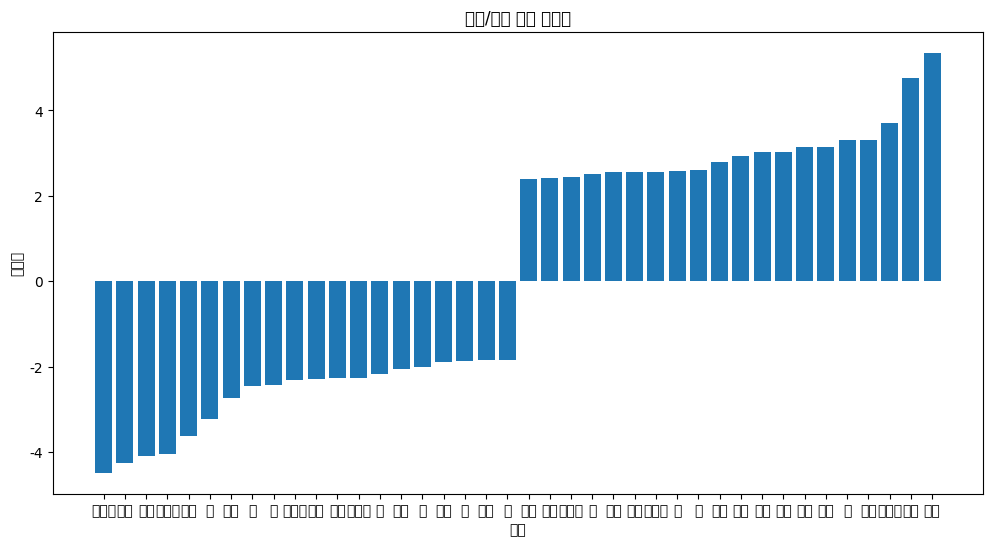

In [109]:
plt.figure(figsize=(12,6))
plt.title('긍정/부정 단어 가중치')
plt.xlabel('단어')
plt.ylabel('가중치')
plt.bar(top20.index, top20['weight'])
plt.show()